In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_INDY = False
CONNECT_MOBILE = False
USE_SDK = True

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
from enum import Enum
class ExpType(Enum):
    REMOVE_OBS=0
    CONTACT_TAR=1

EXP_SCENARIO = ExpType.REMOVE_OBS

In [3]:
INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.6
COL_COLOR = (1,1,1,0.2)
    
if EXP_SCENARIO == ExpType.REMOVE_OBS: ## Obstacle removing
    BAG_COUNT = 5
    CLOCK_COUNT = 0
    TARGET_COUNT = 5
    LOG_FORCE = False
else: ## Contact 
    BAG_COUNT = 3
    CLOCK_COUNT = 3
    TARGET_COUNT = 5
    LOG_FORCE = True

from pkg.controller.combined_robot import *
from pkg.project_config import *

if not CONNECT_INDY:
    indy_7dof_client.kiro_tool.OFFLINE_MODE = True
kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR))
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True} if not USE_SDK else {})

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

connection command:
kmb0: True
indy1: False


### Make scene

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

if EXP_SCENARIO == ExpType.REMOVE_OBS: ## Obstacle removing
    gscene.set_workspace_boundary(
        -1, 4, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)
else:
    gscene.set_workspace_boundary(
        -1, 4, -1.7, 1.7, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Planning scene

In [5]:
from pkg.geometry.geometry import *
from pkg.utils.code_scraps import *
from pkg.planning.constraint.constraint_subject import *
from pkg.planning.constraint.constraint_actor import *

In [6]:
pscene = PlanningScene(gscene, combined_robot=crob)
ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
CAM_LINK = TIP_LINK.replace("tcp", "link6")
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE
BRUSH_NAME = "brush_face"
brush_face = add_indy_sweep_tool(gscene, ROBOT_NAME, face_name=BRUSH_NAME, tool_offset=0.12, color_col=(0.8,0.8,0.8,0.2))
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayFramer, point=(0,0,brush_face.dims[2]/2), rpy=(0,np.pi,0))
# from demo_utils.environment import add_kiro_indytool_down
# add_kiro_indytool_down(gscene, zoff=0, tool_link="indy1_tcp", face_name="brush_face", ext_off=0.032, tool_dim=(0.08, 0.32))
gscene.show_pose(crob.home_pose)

MOBILE_PUSH_NAME = "mpush"
MOBILE_PUSH_HEIGHT = 0.4
MOBILE_PUSH_KEY = 1
front_dist = 0.46
mpush_g = gscene.create_safe(GEOTYPE.SPHERE, MOBILE_PUSH_NAME, link_name=HOLD_LINK,dims=(0.01,0.01,0.01),
                           center=(front_dist, 0, MOBILE_PUSH_HEIGHT), rpy=(0,np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5))
mpush_b = pscene.create_binder(MOBILE_PUSH_NAME, MOBILE_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=MOBILE_PUSH_KEY)

floor_b = pscene.create_binder("floor_ws", "floor_ws", PlaceFrame, point=(0,0,WALL_THICKNESS/2), key=MOBILE_PUSH_KEY)

TOOL_PUSH_NAME = "tpush"
TOOL_PUSH_HEIGHT = 0.03
TOOL_PUSH_KEY = 10
brush_col = gscene.NAME_DICT[BRUSH_NAME+"_col"]
TOOL_DIM = brush_col.dims
tpush_g = gscene.create_safe(GEOTYPE.SPHERE, TOOL_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=(-TOOL_DIM[0]/2-CLEARANCE, 0, 0), rpy=(0,-np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
tpush_b = pscene.create_binder(TOOL_PUSH_NAME, TOOL_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=TOOL_PUSH_KEY)


## Table

In [7]:
TABLE_DIM = (0.6, 1.2, 0.7)
TABLE_NAME = "table"
TABLE_LOC = (3, 0, TABLE_DIM[2]/2)
TABLE_RPY = (0,0,0)

In [8]:
table_g = gscene.create_safe(GEOTYPE.BOX, TABLE_NAME, link_name="base_link", dims=TABLE_DIM,
                             center=TABLE_LOC, rpy=TABLE_RPY,
                             fixed=True, collision=True, color=(0.8,0.8,0.8,1))
table_b = pscene.create_binder(TABLE_NAME, TABLE_NAME, PlaceFrame, point=(0,0,TABLE_DIM[2]/2), key=TOOL_PUSH_KEY)
gscene.add_virtual_guardrail(table_g, HEIGHT=0.01, axis="xy")

## Waypoints

In [9]:
WP_NAME = "wp_{}"
WP_DIM = (0.1,0.1,0.01)
WP_LOC = (-0.2, 0.0, TABLE_DIM[2]/2+WP_DIM[2]/2)
WP_RPY = (0,0,0)

In [10]:
wp_g_list = []
for i_t in range(TARGET_COUNT):
    wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME.format(i_t), link_name="base_link", dims=WP_DIM,
                              center=(WP_LOC[0], WP_LOC[1]-0.4+i_t*0.2, WP_LOC[2]), rpy=WP_RPY,
                              fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)
    wp_g_list.append(wp_g)
waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                     for wp_g in wp_g_list
                                 })

## Clock

In [11]:
CLOCK_NAME = "clock_{}"
CLOCK_DIM = (0.14,0.05,0.076)
clock_center = np.add(wp_g.center[:2]+(0,), (0,0.1,TABLE_DIM[2]+CLOCK_DIM[2]/2+CLEARANCE))

In [12]:
for i_c in range(CLOCK_COUNT):
    CLOCK_NAME_I = CLOCK_NAME.format(i_c)
    clock_g = gscene.create_safe(GEOTYPE.BOX, CLOCK_NAME_I, link_name="base_link",dims=CLOCK_DIM,
                               center=(clock_center[0], clock_center[1]-i_c*0.4, clock_center[2]), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.8,0.5,0.3,1))

    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(CLOCK_DIM, -R[:,2])/2, 4)
        point[2] = -CLOCK_DIM[2]/2 + TOOL_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, clock_g, point=point, rpy=Rot2rpy(R), key=TOOL_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", clock_g, point=(0,0,-CLOCK_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
                             binded_on=table_b, dist_push_min=0.1, dist_push_max=0.3, dir_push=[-1,0,0], key=TOOL_PUSH_KEY)

    clock_s = pscene.create_subject(oname=CLOCK_NAME_I, gname=CLOCK_NAME_I, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Bag

In [13]:
BAG_NAME = "bag_{}"
BAG_DIM = (0.4, 0.29,0.64)

In [14]:
for i_b in range(BAG_COUNT):
    BAG_NAME_I = BAG_NAME.format(i_b)
    bag_g = gscene.create_safe(GEOTYPE.BOX, BAG_NAME_I, link_name="base_link",dims=BAG_DIM,
                               center=(1.5,0.8*(i_b-int(BAG_COUNT/2)),BAG_DIM[2]/2), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.8,0.8,0.8,1))
    handle = gscene.create_safe(GEOTYPE.BOX, BAG_NAME_I+"_hdl", link_name="base_link",dims=(0.2,0.03,0.02),
                               center=(0,0,BAG_DIM[2]/2+0.01), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.6,0.6,0.6,1), parent=BAG_NAME_I)

    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(BAG_DIM, -R[:,2])/2, 4)
        point[2] = -BAG_DIM[2]/2 + MOBILE_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, bag_g, point=point, rpy=Rot2rpy(R), key=MOBILE_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", bag_g, point=(0,0,-BAG_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
                                               binded_on=floor_b, dist_push_min=0.2, dist_push_max=1.0, key=MOBILE_PUSH_KEY)

    bag_s = pscene.create_subject(oname=BAG_NAME_I, gname=BAG_NAME_I, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

### prepare planner

In [15]:
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *
# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


In [16]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene, enable_dual=False)
mplan.update_gscene()

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=1000, node_count_max=100, allow_joint_motion=True)
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)
mplan.motion_filters = [gcheck, rcheck]
mplan.incremental_constraint_motion = True

ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
[WARN] reach data is not ready for kmb. Ignoring this robot...


### Custom rules

In [17]:
# joint motion is not allowed when pushing object with holder
idc_push = np.where([stype == PushObject for stype in pscene.subject_type_list])[0]
tplan.explicit_rule = lambda pscene, node, leaf: not any([node[idx]==leaf[idx] and "push" in node[idx] for idx in idc_push])

In [18]:
# generate base pose to reach targets
N_samples = 100
# thetas_available = np.array([np.pi/2*i for i in range(4)])
thetas_available = np.array([0, np.pi/2, np.pi*3/2])

xy_list = floor_b.geometry.get_vertice_radius_from(crob.home_dict)[0][:,:2]
xy_max = np.max(xy_list,axis=0)
xy_min = np.min(xy_list,axis=0)

targets = [pscene.subject_dict[sname] for sname, stype in zip(pscene.subject_name_list, pscene.subject_type_list) if stype == WaypointTask]
wps_dict = {target.oname: [target.action_points_dict[wname] for wname in target.action_points_order] for target in targets}
def gen_reaching_base(state):
    if np.sum(np.abs(state.Q-crob.home_pose)[crob.idx_dict[ROBOT_NAME]])>1e-2:
        Q = np.copy(state.Q)
        Q[crob.idx_dict[ROBOT_NAME]] = crob.home_pose[crob.idx_dict[ROBOT_NAME]]
        return Q
    xyt_samples = np.array([np.random.uniform(xy_min, xy_max).tolist()
                            +[np.random.choice(thetas_available)] 
                            for _ in range(N_samples)])

    # check availability for wps
    Twe = np.linalg.inv(brush_b.Toff_lh)
    Tbe_mat = []
    for target in targets:
        i_s = pscene.subject_name_list.index(target.oname)
        ntem = state.node[i_s]
        wps = wps_dict[target.oname][ntem:CUR_TAR] # exclude already reached waypoints
        Tbe_arr = []
        for wp in wps:
            Tbe = np.matmul(wp.get_tf_handle(crob.home_pose), Twe)
            Tbe_arr.append(Tbe)
        Tbe_mat.append(Tbe_arr)
        
    # score with more weights on reachable num on same targets
    score_mat = []
    for i_x, xyt in enumerate(xyt_samples):
        Tbr = gscene.get_tf(ROBOT_BASE, [xyt[0], xyt[1], xyt[2]]+[0]*9)
        score_list = []
        for Tbe_arr in Tbe_mat: # iterate targets
            score_t = 0
            for Tbe in Tbe_arr: # iterate waypoints
                Tre = np.matmul(np.linalg.inv(Tbr), Tbe)
                res = rcheck.check_T(ROBOT_NAME, Tre)
                if res:
                    Q = np.copy(state.Q)
                    Q[:3] = xyt
                    res = mplan.validate_trajectory([Q])
                    score_t += res
            score_list.append(score_t)
        score_mat.append(score_list)
    score_mat = np.square(score_mat) # (pose_num, target_num), square to weight more on large counts
    score_list = np.sum(score_mat, axis=-1,dtype=float)
    score_sum = np.sum(score_list)
    if score_sum>0:
        score_list = np.divide(score_list, score_sum)
        i_select = np.random.choice(range(N_samples), p=score_list)
        Q = np.copy(state.Q)
        Q[:3] = xyt_samples[i_select]
        return Q
    return None

tplan.config_gen = gen_reaching_base

### Plan

In [19]:
gscene.show_pose(crob.home_pose)
chain_list = \
    [BindingChain(BAG_NAME.format(i_b), "bottom_p", "floor_ws", "floor_ws") for i_b in range(BAG_COUNT)] \
    + [BindingChain(CLOCK_NAME.format(i_c), "bottom_p", "table", "table") for i_b in range(CLOCK_COUNT)] \
    + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(crob.home_pose, chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

['bag_0', 'bag_1', 'bag_2', 'bag_3', 'bag_4', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


In [20]:
from_state = initial_state.copy(pscene)
snode_schedule_all = []
for i_t in range(1, TARGET_COUNT+1):
    CUR_TAR = i_t
    goal_nodes = [('floor_ws',)*BAG_COUNT+ ('table',)*CLOCK_COUNT + (i_t,)]
    break
    ppline.search(from_state, goal_nodes, max_solution_count=1,
                  verbose=False, display=False, dt_vis=0.01, 
                  timeout=0.5, timeout_loop=100, 
                  multiprocess=True, add_homing=False)
    snode_schedule = tplan.get_best_schedule(at_home=False)
    snode_schedule_all += snode_schedule
    from_state = snode_schedule[-1].state.copy(pscene)
    TextColors.BLUE.println("==================== TARGET {} REACHED ====================".format(i_t))
if snode_schedule_all:
    snode_schedule_all += ppline.add_return_motion(snode_schedule_all[-1], initial_state=initial_state)

In [21]:
pscene.set_object_state(initial_state)
gscene.show_pose(initial_state.Q)

In [22]:
try:
    ppline.play_schedule(snode_schedule_all)
except Exception as e:
    print(e)

list index out of range


In [23]:
VISUALIZE = False
HOLD_DEBUG = False
VERBOSE = True

In [24]:
from pkg.utils.utils_graph import *
                
def get_gtem_list_except(pscene, snames):
    gtem_dict = {sname: [pscene.gscene.NAME_DICT[gname] 
                         for gname in subject.geometry.get_family() 
                         if (pscene.gscene.NAME_DICT[gname].collision and 
                             not pscene.gscene.NAME_DICT[gname].fixed)
                        ]
                 for sname, subject in pscene.subject_dict.items()}

    gtem_list = []
    for sname in pscene.subject_name_list:
        if sname not in snames:
            gtem_list += gtem_dict[sname]
    return gtem_list


class Transition:
    def __init__(self, node, rho):
        self.traj = None
        self.rho = rho
        self.node = deepcopy(node)
        
    def set_traj(self, traj):
        self.traj = traj
        
##
# @class BindingTransition
# @remark set btf=None, state_param=None to sample states when possible
class BindingTransition(Transition):
    def __init__(self, subject_name, btf, state_param, **kwargs):
        Transition.__init__(self,**kwargs)
        self.subject_name = subject_name
        self.btf, self.state_param = btf, state_param
        
class JointTransition(Transition):
    def __init__(self, pscene, rname, Q, **kwargs):
        Transition.__init__(self, **kwargs)
        self.rname = rname
        self.Q = np.copy(Q)
        self.idc_joints = pscene.combined_robot.idx_dict[rname]
        
##
# @class    IncrementalSearch
class IncrementalSearch(TaskInterface):
    ##
    # @param    pscene              rnb-planning.src.pkg.planning.scene.PlanningScene
    # @param    allow_joint_motion  allow random joint motion, which is transition to same node. \r\n
    # @param    config_gen          configuration generator for random joint motion. by default, this homing motion is generated.
    # @param    rho                 default priority
    # @param    gamma               decay ratio
    def __init__(self, pscene, gcheck, rcheck, allow_joint_motion=False, config_gen=None,
                 explicit_rule=None, rho=0.5, gamma=0.5):
        TaskInterface.__init__(self, pscene)
        
        self.gcheck, self.rcheck = gcheck, rcheck
        self.allow_joint_motion = allow_joint_motion
        self.config_gen = config_gen
        self.explicit_rule = (lambda pscene, node, leaf: True) if explicit_rule is None else explicit_rule
        self.rho = rho
        self.gamma = gamma

    ##
    # @brief build object-level node graph
    def prepare(self):
        pscene = self.pscene

        # make all node connections
        self.node_list = pscene.get_all_nodes()
        self.node_dict_full = {k: [k] if self.allow_joint_motion else [] for k in self.node_list}
        self.node_parent_dict_full = {k: [k] if self.allow_joint_motion else [] for k in self.node_list}
        for node in self.node_list:
            for leaf in pscene.get_node_neighbor(node):
                if leaf in self.node_list:
                    self.node_dict_full[node].append(leaf)
                    self.node_parent_dict_full[leaf].append(node)
        for node in self.node_list:
            self.node_dict_full[node] = set(self.node_dict_full[node])
            self.node_parent_dict_full[node] = set(self.node_parent_dict_full[node])

    ##
    # @brief calculate initial/goal scores and filter valid nodes
    def init_search(self, initial_state, goal_nodes, **kwargs):
        self.initial_state = initial_state
        self.goal_nodes = goal_nodes

        self.node_dict = {}
        self.node_parent_dict = defaultdict(set)
        for node, leafs in self.node_dict_full.items():
            ## goal node does not have child leaf
            if node in goal_nodes:
                self.node_dict[node] = set()
                continue
            leaf_list = [leaf
                         for leaf in leafs
                         if self.explicit_rule(self.pscene, node, leaf)]
            self.node_dict[node] = set(leaf_list)
            for leaf in self.node_dict[node]:
                self.node_parent_dict[leaf].add(node)
        self.node_parent_dict = dict(self.node_parent_dict)
        
        self.error_dict = score_graph(self.node_parent_dict, goal_nodes)
        self.cost_dict = score_graph(self.node_dict, initial_state.node)
        nodes_valid = sorted(set(self.cost_dict.keys()).intersection(self.error_dict.keys()))
        self.score_dict = {}
        for node in nodes_valid:
            self.score_dict[node] = self.error_dict[node] + self.cost_dict[node]
            
        snode_root = self.make_search_node(None, initial_state, None)
        self.connect(None, snode_root)
        self.update(None, snode_root, True)

    ##
    # @brief (prototype) update connection result to the searchng algorithm
    def update(self, snode_src, snode_new, connection_result):
        if connection_result:
            if self.check_goal(snode_new.state):
                print("Goal reached")
                return True
        return False
    
    def get_transited_state(self, state, transition):
        to_state = state.copy(self.pscene)
        if isinstance(transition, BindingTransition):
            to_state.binding_state[transition.subject_name] = transition.btf
            to_state.state_param[transition.subject_name] = transition.state_param
            to_state.set_binding_state(self.pscene, to_state.binding_state, to_state.state_param)
        elif isinstance(transition, JointTransition):
            to_state.Q[transition.idc_joints] = transition.Q
        else:
            raise(NotImplementedError("non-implemented transition type {}".format(transition.__class__.__name__)))
        return to_state
    
    def calc_priority(self, snode_from, transitions):
        to_node = transitions[-1].node
        rho = 1.0
        for transition in transitions:
            rho *= transition.rho
        return -rho*self.rho**self.error_dict[to_node]
    
    ##
    # @param snode_from  SearchNode from which transitoin will be made
    # @param transition  BindingTransform or JointTransition
    def queue_transition(self, snode_from, transitions):
        if isinstance(transitions[0], BindingTransition):
            assert transitions[0].btf != None, "here"
        self.transition_queue.put((self.calc_priority(snode_from, transitions), 
                                   (snode_from.idx, deepcopy(transitions))))

    ##
    # @brief sample leaf states for all available binding changes
    def queue_transitions_all(self, snode_from, leafs=None, reserveds=[], snames=None, 
                              constraint_fun=None, sample_all=False, rho=None):
        transitions = self.sample_transitions(snode_from.state, leafs, snames=snames, 
                                             constraint_fun=constraint_fun, sample_all=sample_all, rho=rho)
        
        for bts in transitions:
            self.queue_transition(snode_from, [bts]+reserveds)
    
    def sample_transitions(self, from_state, leafs=None, snames=None, 
                          constraint_fun=None, sample_all=False, rho=None):
        if rho is None:
            rho = self.rho
        if leafs is None:
            leafs = [leaf for leaf in self.node_dict[from_state.node] if leaf in self.error_dict]
            
        if snames is not None:
            leafs_s = []
            for sname in snames: # pick if target subject is changed
                i_s = self.pscene.subject_name_list.index(sname)
                leafs_s += [leaf for leaf in leafs if leaf[i_s] != from_state.node[i_s]]
            leafs = leafs_s
        
        if leafs:
            bts_list = []
            error_min = np.min([self.error_dict[leaf] for leaf in leafs])
            leafs = [leaf for leaf in leafs if self.error_dict[leaf] == error_min]
            random.shuffle(leafs)

            for leaf in leafs:
                available_binding_dict = self.pscene.get_available_binding_dict(from_state, leaf)
                to_state = self.pscene.sample_leaf_state(from_state, available_binding_dict, leaf)
                snames, succ = self.pscene.get_changing_subjects(from_state, to_state)
                random.shuffle(snames)
                for sname in snames:
                    bts = BindingTransition(
                        sname, to_state.binding_state[sname], to_state.state_param[sname], 
                        node=to_state.node, rho=rho)
                    if constraint_fun is not None and not constraint_fun(from_state, bts):
                        continue
                    if not sample_all:
                        return [bts]
                    bts_list.append(bts)
            return bts_list
        else:
            return []
            
    def sample_pick_put(self, snode_from, sname_list):
        state = snode_from.state
        Q_dict = list2dict(state.Q, self.pscene.gscene.joint_names)
        sname_list = deepcopy(sname_list)
        random.shuffle(sname_list)
        pick_put_all = []
        for sname in sname_list:
            subject = self.pscene.subject_dict[sname]
            btf = state.binding_state[sname]
            state_param = state.state_param[sname]
            pick_put = False
            subject.set_state(btf, state_param)
            bts_pick_list = self.sample_transitions(state, snames=[sname], sample_all=True)
            random.shuffle(bts_pick_list)
            for bts_pick in bts_pick_list:
                if self.gcheck.check(bts_pick.btf, Q_dict): 
                    subject.set_state(bts_pick.btf, state_param)
                    bts_put_list = self.sample_transitions(state, snames=[sname], sample_all=True)
                    random.shuffle(bts_put_list)
                    for bts_put in bts_put_list:
                        if self.gcheck.check(bts_put.btf, Q_dict):
                            if VISUALIZE:
                                self.pscene.show_binding(bts_pick.btf)
                                self.pscene.show_binding(bts_put.btf)
                                time.sleep(0.01)
                                self.pscene.gscene.clear_highlight()
                            pick_put = [bts_pick, bts_put]
                            break
                    if pick_put:
                        break
            subject.set_state(btf, state_param)
            if pick_put:
                pick_put_all += pick_put
            else:
                # fail! just return
                return
        return pick_put_all

    def trace_back(self, snode_from, transitions):
        # trace back one edge
        transition = transitions[0]
        snode_next = snode_from
        snode_from = self.snode_dict[snode_from.parents[-1]]
        state = snode_next.state
        transition = BindingTransition(
            sname, state.binding_state[sname], state.state_param[sname], 
            node=state.node, rho=transition.rho)
        transition.set_traj(snode_next.traj)
        transitions = [transition] + transitions
        return snode_from, transitions

    ##
    # @brief check if a state is in pre-defined goal nodes
    # @param state rnb-planning.src.pkg.planning.scene.State
    def check_goal(self, state):
        return state.node in self.goal_nodes

In [25]:
class ConstraintResolver:
    @abstractmethod
    def check(self, state, transition, skip_set_state=False):
        raise(NotImplementedError("check is not implemented for {}".format(self.__class__.__name__)))
    
    @abstractmethod
    def resolve(self, snode_from, reason, transitions):
        raise(NotImplementedError("resolve is not implemented for {}".format(self.__class__.__name__)))
    

class CollisionResolver(ConstraintResolver):
    ##
    # @param inc IncrementalSearch instance
    # @param gcheck GraspChecker
    def __init__(self, inc, gcheck):
        self.inc, self.gcheck = inc, gcheck
        self.pscene = inc.pscene
        
    def check(self, state, transition, skip_set_state=False):        
        if not skip_set_state:
            self.pscene.set_object_state(state)
            
        if isinstance(transition, BindingTransition):
            Q_dict = list2dict(state.Q, self.pscene.gscene.joint_names)
            dist_dict = self.gcheck.check(transition.btf, Q_dict, return_dist_dict=True)
            if VISUALIZE:
                self.pscene.show_binding(transition.btf)

            collision_set = set()
            for aname, adict in dist_dict.items():
                for oname, dist in adict.items():
                    if dist<=1e-6:
                        collision_set.add(aname)
                        collision_set.add(oname)
                        if VISUALIZE:
                            self.pscene.gscene.highlight_geometry("hl_cresv", oname, color=(1,0,0,0.5))
                            self.pscene.gscene.highlight_geometry("hl_cresv", aname, color=(0,0,1,0.5))

            if VISUALIZE:
                self.pscene.gscene.clear_highlight()
            gtem_dict = {}
            col_tems = []
            for sname, subject in self.pscene.subject_dict.items():
                gfam = subject.geometry.get_family()
                gtem_dict[sname] = gfam
                if collision_set.intersection(gfam):
                    col_tems.append(sname)
            reason = col_tems
        elif isinstance(transition, JointTransition):
            reason=False
        else:
            raise(NotImplementedError("Undefined transition type {}".format(transition.__class__.__name__)))
            
        return reason
    
    def resolve(self, snode_from, reason, transitions):
        assert reason, "resolve is supposed to called only when there is failure reason"
        state = snode_from.state
        for sname in reason:
            if self.pscene.subject_dict[sname].geometry.fixed:
                # fixed collision is not resolvable - trace back!!
                return
            
        transition = transitions[0]
        if self.pscene.actor_robot_dict[transition.btf.chain.actor_name] == None:
            # this is placement. trace back to pick 
            snode_from, transitions = self.inc.trace_back(snode_from, transitions)
        
        pick_put_all = self.inc.sample_pick_put(snode_from, reason)
        if pick_put_all is not None:
            self.inc.queue_transition(snode_from, pick_put_all+transitions)


In [26]:
class ReachResolver(ConstraintResolver):
    ##
    # @param inc IncrementalSearch instance
    # @param gcheck GraspChecker
    def __init__(self, inc, rcheck, mplan, floor=None, N_try_max=100):
        self.inc, self.rcheck, self.mplan = inc, rcheck, mplan
        self.pscene = inc.pscene
        self.crob = self.pscene.combined_robot
        self.rconfig_dict = crob.get_robot_config_dict()
        
        self.N_try_max = N_try_max
        self.floor = floor
        if floor is not None:
            xy_list = floor_b.geometry.get_vertice_radius_from(crob.home_dict)[0][:,:2]
            self.xy_max = np.max(xy_list,axis=0).tolist()
            self.xy_min = np.min(xy_list,axis=0).tolist()

    def check(self, state, transition, skip_set_state=False):
        if not skip_set_state:
            self.pscene.set_object_state(state)
        if isinstance(transition, BindingTransition):
            Q_dict = list2dict(state.Q, self.pscene.gscene.joint_names)
            if VISUALIZE:
                self.pscene.gscene.show_pose(state.Q)
                self.pscene.show_binding(transition.btf)
            success = self.rcheck.check(transition.btf, Q_dict)
            if VISUALIZE:
                self.pscene.gscene.clear_highlight()
        elif isinstance(transition, JointTransition):
            success = True
        else:
            raise(NotImplementedError("Undefined transition type {}".format(transition.__class__.__name__)))
            
        return not success
    
    def resolve(self, snode_from, reason, transitions):
        state = snode_from.state
        transition = transitions[0]
        assert reason, "resolve is supposed to called only when there is failure reason"
        if VERBOSE: print("resolve reach from {}".format(np.round(state.Q, 2)))

        btf_cur = state.binding_state[transition.subject_name]
        ref_link = self.pscene.subject_dict[transition.subject_name].geometry.link_name # assume new actor is active, get currently attached object link
        aname = transition.btf.chain.actor_name # get new active actor
        T_loal = transition.btf.T_loal # get Tf from static object to active actor

        if self.pscene.actor_robot_dict[aname] is None: # if target transition actor is not on robot
            aname_to = aname
            aname = btf_cur.chain.actor_name
            T_loal = transition.btf.T_laol
            ref_link = transition.btf.actor_link
            # currently bound actor should be on robot
            assert aname_from in self.pscene.actor_robot_dict, \
                "no controllable actor in transition of {}: {} -> {}".format(transition.subject_name, aname, aname_to)

        rname = self.pscene.actor_robot_dict[aname]
        rconfig = self.rconfig_dict[rname]
        rbase = self.pscene.robot_chain_dict[rname]["link_names"][0]

        if rconfig.root_on == "base_link":
            if VERBOSE: print("robot is not movable - just return")
            return

        mlink = rconfig.root_on
        Tmr = self.pscene.gscene.get_tf(rbase, state.Q, from_link=mlink)
        Trm = np.linalg.inv(Tmr)

        for mname, mchain in self.pscene.robot_chain_dict.items():
            if rconfig.root_on in mchain['link_names']:
                break
            else:
                mname=None
        assert mname is not None, "mobile robot not found for {} - root link={}".format(rname, rconfig.root_on)

        idc_robot = self.crob.idx_dict[rname]
        idc_mobile = self.crob.idx_dict[mname]

        Q = np.copy(state.Q)
        home_transitions = []
        if not np.all(np.abs(self.crob.home_pose[idc_robot] - Q[idc_robot])<1e-2): # if robot is not at home
            if VERBOSE: print("home robot {}".format(state.node))
            home_transitions.append(JointTransition(
                self.pscene, rname, self.crob.home_pose[idc_robot], 
                node=state.node, rho=self.inc.rho)) # move robot to home config
            Q[idc_robot] = self.crob.home_pose[idc_robot]

        radii_max = np.linalg.norm(rconfig.xyzrpy[0][:2])+RobotSpecs.get_shoulder_reach(rconfig.type)
        sample_count = 0
        for _ in range(self.N_try_max):
            r_loc, theta_loc, theta = np.random.uniform([0,-np.pi, -np.pi], [radii_max, np.pi, np.pi])
            xyz_lr = np.matmul(Rot_axis(3, theta_loc), [r_loc, 0, 0])[:3]
            xyz_br = T_loal[:3,3] + xyz_lr
            Tbr = SE3(Rot_axis(3, theta), xyz_br)
            Tbm = np.matmul(Tbr, Trm)
            xy_bm = Tbm[:2,3]
            theta_bm = Rot2axis(Tbm[:3,:3], 3)
            xyt = np.array(xy_bm.tolist()+[theta_bm])
            Qmb = xyt.tolist()+[0]*3

            if self.floor is not None and not(np.all(xy_bm>self.xy_min) and np.all(xy_bm<self.xy_max)):
                continue

            Q[idc_mobile] = Qmb
            Tbr = gscene.get_tf(rbase, Q, from_link=ref_link)
            Trb = np.linalg.inv(Tbr)
            Tre = np.matmul(Trb, T_loal)
            res = rcheck.check_T(rname, Tre)
            if res:
                if VISUALIZE:
                    self.pscene.gscene.show_pose(Q)
                res = self.mplan.validate_trajectory([Q], ignore=get_gtem_list_except(self.pscene, [])) 
            if res:
                if HOLD_DEBUG:
                    raw_input()
                if VERBOSE: print("move base {}".format(state.node))
                transition_new = JointTransition(self.pscene, mname, Qmb, node=state.node, rho=self.inc.rho)
                self.inc.queue_transition(snode_from, transitions=home_transitions + [transition_new] + transitions)
                return
        if VERBOSE: print("reach not resolved")

In [27]:
class MotionResolver(ConstraintResolver):
    ##
    # @param inc IncrementalSearch instance
    # @param gcheck GraspChecker
    def __init__(self, inc, mplan, **kwargs):
        self.inc, self.mplan = inc, mplan
        self.pscene = inc.pscene
        self.kwargs = kwargs

    def check(self, state, transition, skip_set_state=False):
        if not skip_set_state:
            self.pscene.set_object_state(state)
            
        if isinstance(transition, BindingTransition):
            subject_list = [transition.subject_name]
        elif isinstance(transition, JointTransition):
            subject_list = []
        else:
            raise(NotImplementedError("Undefined transition type {}".format(transition.__class__.__name__)))
            
        to_state = self.inc.get_transited_state(state, transition)
        if VISUALIZE:
            self.pscene.gscene.show_pose(state.Q)
            if isinstance(transition, BindingTransition):
                self.pscene.show_binding(transition.btf)
            elif isinstance(transition, JointTransition):
                time.sleep(0.01)
                self.pscene.gscene.show_pose(to_state.Q)
        
        col_tems_all = deepcopy(subject_list) # do not ignore target subject from begining
        reason = []
        while True:
            subjects_remain = list(set(self.pscene.subject_name_list) - set(col_tems_all))
            
#             if not reason and transition.traj is not None:
#                 # first trial and use previously saved trajectory
#                 Traj = transition.traj
#                 success = True
#             else:
            # ignore all except previously collided subject
            gtems_ignore = get_gtem_list_except(self.pscene, col_tems_all)
            Traj, LastQ, error, success = self.mplan.plan_algorithm(
                state, to_state, subject_list, ignore=gtems_ignore, **self.kwargs)

            if not success:
                if VISUALIZE:
                    self.pscene.gscene.show_motion(Traj)
                # If failed to find trajectory, end there
                break
                
            # get colliding items with the trajectory
            col_tems = []
            for sname in subjects_remain:
                # ignore all gtems except for sname to check collision
                ignore = get_gtem_list_except(self.pscene, [sname])
                res = self.mplan.validate_trajectory(Traj, ignore=ignore) 
                if not res:
                    col_tems.append(sname)
            if VISUALIZE:
                for sname in col_tems:
                    gnames = self.pscene.gscene.NAME_DICT[sname].get_family()
                    for gname in gnames:
                        self.pscene.gscene.highlight_geometry("mresv", gname, color=(1, 1, 0, 0.5))
                self.pscene.gscene.show_motion(Traj)
                self.pscene.gscene.clear_highlight()
            reason.append((col_tems, Traj))
            col_tems_all += col_tems
            if not col_tems:
                # If no collision occurs, this is already an answer. no need to try planning more
                break
                
        return reason
    
    def resolve(self, snode_from, reason, transitions):
        state = snode_from.state
        subj_seq = [trs.subject_name for trs in transitions if isinstance(trs, BindingTransition)]
        assert reason, "resolve is supposed to called only when there is failure reason"
        snode_new = None
        
        transitions_pre= []
        transition = transitions[0]
        reserveds = transitions[1:]
        snode_next = snode_from
        if isinstance(transition, BindingTransition):
            if self.pscene.actor_robot_dict[transition.btf.chain.actor_name] == None:
                # this is placement. trace back to pick 
                snode_from, transitions = self.inc.trace_back(snode_from, transitions)
                transitions_pre = [transitions[0]]
        
        for col_tems, Traj in reason:
            if not col_tems: # validated trajectory
                to_state = self.inc.get_transited_state(snode_next.state, transition)
                to_state.Q = Traj[-1]
                snode_new = inc.make_search_node(snode_next, to_state, Traj)
                self.inc.connect(snode_next, snode_new)
                if VISUALIZE:
                    self.pscene.gscene.show_motion(Traj)
                if VERBOSE:
                    print("valid transition found: {} - {}".format(snode_next.state.node, snode_new.state.node))
                if reserveds:
                    self.inc.queue_transition(snode_new, transitions=reserveds) # que transitions to reach goal
                else:
                    self.inc.queue_transitions_all(snode_new) # que transitions to reach goal
                continue
                
            transition_traj = deepcopy(transition)
            transition_traj.set_traj(Traj)
            random.shuffle(col_tems)
            for col_tem in col_tems:
                pick_put_all = self.inc.sample_pick_put(snode_from, [col_tem])
                if pick_put_all is not None:
                    self.inc.queue_transition(
                        snode_from, transitions=pick_put_all+transitions_pre+[transition_traj]+reserveds)
        return snode_new

In [28]:
inc = IncrementalSearch(pscene, gcheck, rcheck)
inc.prepare()

In [29]:
cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan, floor=floor_b.geometry)
mresv = MotionResolver(inc, mplan, timeout=0.5)
inc.resolver_stack = [cresv, rresv, mresv]

In [30]:
self = inc
goal_nodes = [('floor_ws',)*5+(5,)]
max_sol = 5
# def search(self, initial_state, goal_nodes, max_sol=5):
self.initialize_memory(None)
self.init_search(initial_state, goal_nodes)
self.transition_queue = PriorityQueue()
self.max_sol = max_sol
self.sol_num = 0
self.queue_transitions_all(self.snode_dict[0])
# while not transition_queue.empty():
#     self.try_extend(*transition_queue.get()[1])

In [31]:
for priority, (idx_from, transitions) in sorted(inc.transition_queue.elements):
    transition = transitions[0]
    to_state = inc.get_transited_state(inc.snode_dict[idx_from].state, transition)
    print(priority, transition.subject_name, to_state.node)

(-0.03125, 'waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 1))


### step_search()

In [32]:
VISUALIZE = True
HOLD_DEBUG = False

In [33]:
# def step_search():
for i_step in range(1000):
    if self.transition_queue.empty():
        raise(RuntimeError("[Error] Transition Queue Empty"))
    priority, (idx_from, transitions) = self.transition_queue.get()
    snode_from = inc.snode_dict[idx_from]
    transition = transitions[0]
#     print("=============== {} ===================".format(i_step))
#     print("{}: {} -> {}".format(snode_from.idx, snode_from.state.node, transition.node))
    # queue repeat
    if isinstance(transition, BindingTransition):
        self.queue_transitions_all(snode_from, snames=[transition.subject_name], reserveds=transitions[1:], rho=self.gamma*transition.rho)
        
    self.pscene.set_object_state(snode_from.state)
    for resv in inc.resolver_stack:
        reason = resv.check(snode_from.state, transitions[0], skip_set_state=True)
        if reason:
            snode_new = resv.resolve(snode_from, reason, transitions)
            if snode_new is not None and self.check_goal(snode_new.state):
                self.sol_num += 1
            break
    if self.sol_num >= self.max_sol:
        break
                    
        

resolve reach from [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.57  0.   -1.57  0.  ]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
resolve reach from [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.57  0.   -1.57  0.  ]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
resolve reach from [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.57  0.   -1.57  0.  ]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
resolve reach from [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.57  0.   -1.57  0.  ]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
resolve reach from [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.57  0.   -1.57  0.  ]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
resolve reach from [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.57  0.   -1.57  0.  ]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0

reach not resolved
resolve reach from [ 2.13  0.07 -1.75  0.    0.    0.   -1.8   0.84  0.65  0.    1.64 -3.56]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2) - ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
resolve reach from [ 2.13  0.07 -1.75  0.    0.    0.   -1.8   0.84  0.65  0.    1.64 -3.56]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2) - ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
resolve reach from [ 2.13  0.07 -1.75  0.    0.    0.   -1.8   0.84  0.65  0.    1.64 -3.56]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
move base ('floor_ws'

In [34]:
sorted_elements = sorted(self.transition_queue.elements)
idx_list = []
for idx, item in enumerate(sorted_elements):
    score = item[0]
    idx_from = item[1][0]
    transitions = item[1][1]
    transition = transitions[0]
    print("{} ({}): {} -> {} ({})".format(
        idx, score, idx_from, 
        (transition.subject_name, transition.node) 
        if isinstance(transition, BindingTransition) else transition.rname, 
        len(transitions)))

0 (-0.125): 33 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 5)) (1)
1 (-0.0625): 29 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 4)) (1)
2 (-0.0625): 30 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 5)) (1)
3 (-0.0078125): 28 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 3)) (1)
4 (-0.00390625): 24 -> indy1 (3)
5 (-0.00390625): 24 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 3)) (1)
6 (-0.001953125): 19 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)) (1)
7 (-0.001953125): 20 -> indy1 (3)
8 (-0.001953125): 20 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 3)) (1)
9 (-0.001953125): 24 -> indy1 (3)
10 (-0.0009765625): 15 -> ('waypoints', ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 1)) (1)
11 (-0.0009765625): 16 -> indy1 (3)
12 (-0.0009765625): 16 -

In [35]:
for idx, snode in sorted(inc.snode_dict.items()):
    print("{}: {} -> {}".format(idx, snode.parents, snode.state.node))

0: [] -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
1: [0] -> ('floor_ws', 'mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
2: [0] -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
3: [0] -> ('floor_ws', 'mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
4: [0, 3] -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
5: [0] -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
6: [0] -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
7: [0, 5] -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
8: [0, 5, 7] -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
9: [0, 5, 7, 8] -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
10: [0, 5, 7] -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
11: [0, 5, 7, 10] -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
12: [0, 5, 7] -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
13: [0, 5, 7, 8] 

### Get snode schedule

In [35]:
def get_schedule_to(inc, snode):
    schedule = [snode]
    while snode.parents:
        snode = inc.snode_dict[snode.parents[-1]]
        schedule = [snode] + schedule
    return schedule

In [36]:
snode_cur = sorted(inc.snode_dict.values(), 
                   key=lambda x: (inc.error_dict[x.state.node],
                                  -len(get_schedule_to(inc, x)))
                  )[0]
print("{}({})".format(snode_cur.state.node, snode_cur.idx))
snode_list = [snode_cur]
while snode_cur.parents:
    snode_cur = inc.snode_dict[snode_cur.parents[-1]]
    snode_list = [snode_cur] + snode_list

('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 5)(31)


### play schedule

In [37]:
for snode_pre, snode_nxt in zip(snode_list[:-1], snode_list[1:]):
    print("{}->{}: {} -> {}".format(snode_pre.idx, snode_nxt.idx, snode_pre.state.node, snode_nxt.state.node))
    pscene.set_object_state(snode_pre.state)
    gscene.show_pose(snode_pre.state.Q)
    gscene.show_motion(snode_nxt.traj)

0->3: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
3->5: ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
5->7: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
7->12: ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
12->13: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
13->14: ('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
14->15: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0) -> ('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
15->16: ('floor_ws', 'floor_ws', 'floor_ws', 'floor_

In [96]:
from pkg.utils.graph_visualize import *

In [97]:
vg = VisualGraph()

In [98]:
def simplify_node(node):
    return tuple([ntem[0] if isinstance(ntem, str) else ntem for ntem in node])

for node, leafs in astar.node_dict.items():
    vg.add_node(simplify_node(node), [simplify_node(leaf) for leaf in leafs])

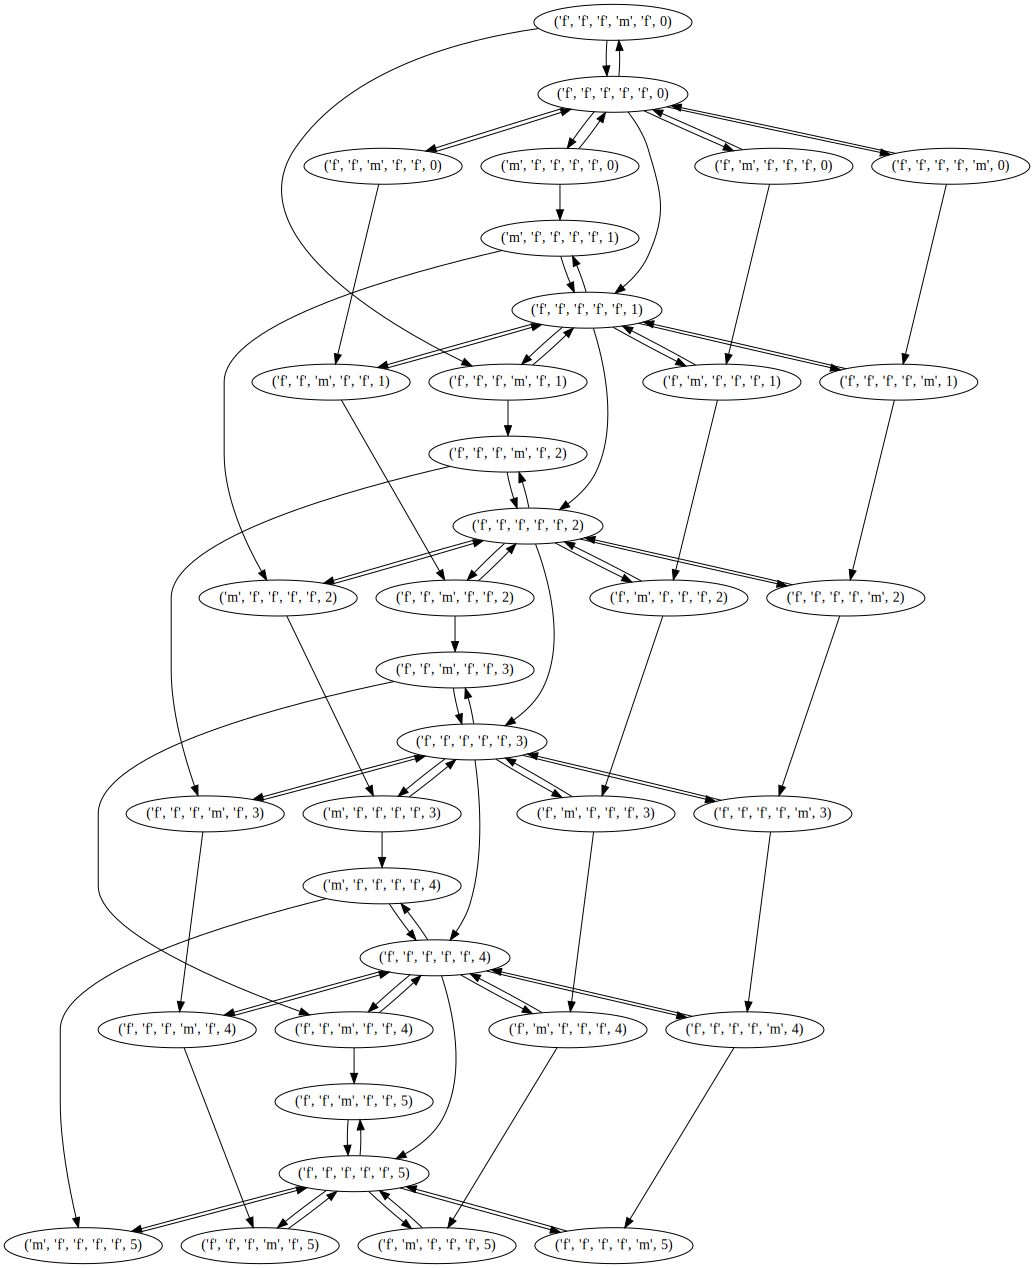

In [99]:
vg.draw()

In [29]:
node_cost_dict

{('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 1): 0}

In [26]:
for node, leafs in astar.node_dict.items():
    print(len(leafs))

6
1
2
2
2
2
2
5
6
2
1
2
1
2
2
6
0
2
1
2
2
2
2
6
2
2
2
2
1
2
2
2
2
2
2
2
